# DCGAN for Generating Fashion MNIST Images

This notebook uses Deep Convolutional Generative Adversarial Networks (DCGANs) to dynamically generate images of fashion items from the MNIST dataset. This deep learning application trains a GAN model to learn the patterns and variations present in the Fashion MNIST dataset, enabling it to generate synthetic images of fashion items.

In [ ]:
# Imports
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dropout, Dense, Flatten, LeakyReLU, Reshape, BatchNormalization, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from skimage.io import imread

# Deep Convolutional Generative Adversarial Networks (DCGANs)

A Generative Adversarial Network (GAN) is a type of deep learning model consisting of two neural networks, a generator, and a discriminator, trained simultaneously through adversarial training. The primary goal of a GAN is to generate realistic data, such as images, that is indistinguishable from genuine data. In our case, the GAN we are using is refered to as a DCGAN because it uses convolutional layers instead of traditional dense layers. The use of these convolutional layers is what makes our model a DCGAN.

Here's a brief summary of how a GAN works:

1. **Generator:**
   - The generator takes random noise or a random input as an initial seed and transforms it into data (in our case an image of a fashion item).
   - It tries to create data that is realistic and similar to the actual training data.
   - It's goal is to have its output fool the Discriminator.

2. **Discriminator:**
   - The discriminator is a binary classifier that evaluates whether an input is real (from the actual dataset) or fake (generated by the generator).
   - It is trained to correctly classify real and fake data.
   - It's goal is to detect whether an input is a product of the generator.

3. **Adversarial Training:**
   - The generator and discriminator are trained simultaneously in a competitive manner.
   - The generator aims to generate increasingly realistic data to fool the discriminator.
   - The discriminator strives to improve its ability to distinguish between real and generated data.


## Overview of the Fashion MNIST Dataset

The Fashion MNIST dataset is a popular benchmark dataset in the field of machine learning, specifically for computer vision. It is often used as a more challenging alternative to the traditional handwritten digit MNIST dataset. Fashion MNIST was designed to test and evaluate the performance of image classification models on a range of fashion items.

Here are key characteristics of the Fashion MNIST dataset:

1. **Image Content:** The dataset consists of grayscale images (1 channel) with a resolution of 28x28 pixels. Each image represents a fashion item or accessory.

2. **Classes:** Fashion MNIST contains 10 different classes, each corresponding to a specific type of clothing or fashion accessory. The classes are as follows:
   - 0: T-shirt/top
   - 1: Trouser
   - 2: Pullover
   - 3: Dress
   - 4: Coat
   - 5: Sandal
   - 6: Shirt
   - 7: Sneaker
   - 8: Bag
   - 9: Ankle boot

3. **Dataset Size:** It comprises a training set with 60,000 examples and a test set with 10,000 examples.


### Examples of MNIST Images:

In [2]:
# Fashion MNIST Classes
classes = [
  "T-shirt/top",
  "Trouser",
  "Pullover",
  "Dress",
  "Coat",
  "Sandal",
  "Shirt",
  "Sneaker",
  "Bag",
  "Ankle boot"
]

4422102/4422102 [==============================] - 0s 0us/step


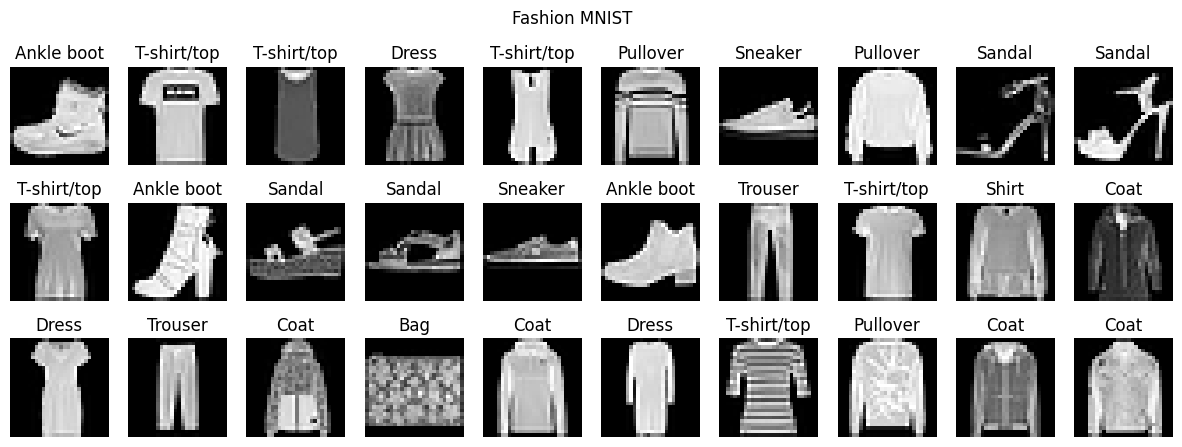

In [3]:
# Load the MNIST Dataset
mnist = tf.keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Plot some example images from the MNIST dataset
plt.figure(figsize=(15, 5))
plt.suptitle("Fashion MNIST")
for i in range(30):
    plt.subplot(3, 10, i+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.title(f'{classes[y_train[i]]}')
    plt.axis('off')

# Preprocessing the Dataset

This will involve preprocessing the MNIST dataset from keras (most of the work is done).

**This will involve:**

1. Combining the train and test sets into a single train set.
2. Normalize the input images

In [4]:
# Combine train and test sets into one set
X_train = np.append(X_train, X_test, axis=0)
y_train = np.append(y_train, y_test, axis=0)
print("X_train shape:", X_train.shape)
print("Y_train shape:", y_train.shape)

X_train shape: (70000, 28, 28)
Y_train shape: (70000,)


In [5]:
# Get the Range of Values in X_train
print("Min Value:", np.min(X_train))
print("Max Value:", np.max(X_train))

Min Value: 0
Max Value: 255


In [6]:
# Normalize the Image Pixels (values between -1 and +1)
X_train = 2 * (X_train / 255.0) - 1
print("New Min Value:", np.min(X_train))
print("New Max Value:", np.max(X_train))

New Min Value: -1.0
New Max Value: 1.0


# Define the Models

Now great functions to define the Generator, Discriminator, and GAN (combined) models. Much of the inspiration around defining these models architecture is based on the findings from the "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks" conference paper [1].

Findings from this paper include:
1. Success using Batchnorm in generator and discriminator (except in output layers) [1].
2. Success using ReLu in Generator (still use tanh for output layer) [1].
3. Success using Leaky ReLu (slope 0.2) in the Discriminator (still use sigmoid for output layer) [1].
4. Success using Adam optimizer with learning rate of 0.0002 and momentum of 0.5 [1].

*Note: define in funtions so 'x' and 'i' variables can be reused.*

In [7]:
# Define the Generator Model
def get_generator(latent_dim):

  # Input Layer (Takes 1D Array of Noise)
  i = Input(shape=(latent_dim,))

  # Hidden Convolutional Layers with Batch Normalization
  x = Dense(7 * 7 * 128)(i)
  x = Reshape([7, 7, 128])(x)
  x = BatchNormalization()(x)
  x = Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2DTranspose(1, kernel_size=4, strides=2, padding="same", activation='tanh')(x)

  # Return the Model
  return Model(i, x)

In [8]:
# Define the Discriminator Model
def get_discriminator():

  # Input Layer (Takes 2D image)
  i = Input(shape=(28, 28, 1))

  x = Conv2D(64, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.2))(i)
  x = BatchNormalization()(x)
  x = Conv2D(128, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.2))(x)
  x = Dropout(0.4)(x)
  x = Flatten()(x)
  x = Dense(1, activation='sigmoid')(x)

  # Declare the Model
  model = Model(i, x)

  # Compile the Model
  model.compile(
      optimizer = Adam(learning_rate=0.002, beta_1=0.5),
      loss = 'binary_crossentropy',
      metrics = ['accuracy']
  )

  # Return the Model
  return model

In [9]:
# Define the GAN (Combined) Model
def get_gan(generator, discriminator, latent_dim):

  # Freeze the Dicriminator (Disable Training)
  discriminator.trainable = False

  # Connect the Generator to Discriminator (Form the GAN)
  i = Input(shape=(latent_dim,))
  x = generator(i)
  x = discriminator(x)

  # Declare Model
  gan = Model(i, x)

  # Compile the Model
  gan.compile(
      optimizer = Adam(learning_rate=0.002, beta_1=0.5),
      loss = 'binary_crossentropy',
  )

  # Return the Model
  return gan

# Construct the Models

1. Declare the size of length of the 1D array of input noise (`latent_dim`).
2. Create the Generator.
3. Create the Discriminator
4. Create the GAN using the Generator and Discriminator.

In [10]:
# Declare Length of 1D Noise Array (Genrator Input)
latent_dim = 100

In [11]:
# Create the Generator
generator = get_generator(latent_dim)

# Create the Discriminator
discriminator = get_discriminator()

# Create the GAN
gan = get_gan(generator, discriminator, latent_dim)

# Train the Networks

Following this, the network is ready to undergo training. Throughout the training process, the generator will be utilized to produce images, which will then be stored in the `gan_images/` directory. These generated images serve as visual indicators, allowing for a detailed observation of the GAN's training progression.

### Saving Images

In this section, we will create a directory called `gan_images` to store the images generated by the GAN. Additionally, we will define a function called `write_image` to write images to this directory throughout the training process.

In [12]:
# Create a directory to save GAN images during training
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [13]:
# Create a function to save images to this directory
def write_image(generator, epoch, latent_dim):
  # Number of Rows and Cols to Print
  rows, cols = 5, 5
  # Generate input noise for each (row,col)
  seeds = np.random.randn(rows*cols, latent_dim)
  # Generate Images
  imgs = generator.predict(seeds)
  # Plot the Generated Images in Subplots
  fig, axs = plt.subplots(rows, cols)
  fig.suptitle('Images at %s Epochs' % epoch)
  p = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[p].reshape(28, 28), cmap='gray')
      axs[i,j].axis('off')
      p += 1
  # Save the Plot as .png
  fig.savefig("gan_images/%d.png" % epoch)
  # Close Image Writer
  plt.close()

### Training Configuration

This section outlines the training configuration for the GAN. The network will be trained using several batchs, with each batch consisting of 64 real or fake images (`batch_size`). In addition, the GAN will be trained for a total of 60 epochs.

Given that each batch is exclusively comprised of either real or fake images, we will assign corresponding labels to denote the nature of the batch. For batches containing fake images, an array of all zeros (`zeros`) will be used, while an array of all ones (`ones`) will signify batches with real images.

In [14]:
# Images Per Batch
batch_size = 64

# Number of Batch
batches = 1000

In [15]:
# Number of Training Epochs
epochs = 60

In [16]:
# Declare Labels for Real (ones) and Fake (zeros) Images
zeros = np.zeros(batch_size)
ones = np.ones(batch_size)

### Training Loop

Now the network can finally be trained. Since the network we are training is a GAN we will have a modify our training strategy. The idea of a GAN is to   adversarially train two networks. To adversarily train the generator and discriminator each training epoch will have the following steps:

1. **Train the Discriminator:**
  - First get two training batchs, one of real images, and one of fake images.The batch of real images will come from selecting images from the Fashion MNIST dataset. The batch of fake images will come from generating fake images from the Generator. Assign labels of 1 to the batch of real images and labels of 0 to the batch of fake images.
  - Next, train the Discriminator on these two two batches (in the code the two batches are combined into one training step for simplicity).
2. **Train the Generator:**
  - Subsequently, the generator undergoes training with the aim of fooling the discriminator. It's essential to note that the GAN model has the discriminator frozen, meaning that training the GAN does not train the discriminator. The GAN operates as a binary classifier, accepting noise as input and producing an output indicating whether the image generated from the input noise is real or fake. Consequently, we train the generator by training the GAN. Our input features will be 1D array of noise and the target will be an output that indicative of a real image. This allows us to train the generator, essentially training it to outsmart the discriminator.
3. **Other Steps:**
  - Print messages indicating the training progress.
  - Calculating and recording the loss per training iteration.
  - Writing images of the generaters progress to the `gan_images/` directory.

In [17]:
# Lists to Store Training Metrics
disc_losses = []
disc_accs = []
gen_losses = []

In [ ]:
# Main training loop
for epoch in range(epochs):

  for batch in range(batches):

    # Get real images from MNIST dataset (number of imgs = batch_size)
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_imgs = X_train[idx]

    # Generate fake imgs using random noise
    noise = np.random.randn(batch_size, latent_dim)
    fake_imgs = generator.predict(noise).reshape(-1, 28, 28)

    # Combine fake and real img sets
    X_imgs, y_imgs = np.vstack((real_imgs, fake_imgs)), np.append(ones, zeros)

    # Train the discriminator using combined img set
    discriminator.trainable = True
    disc_loss, disc_acc = discriminator.train_on_batch(X_imgs, y_imgs)

    # Generate random noise
    noise = np.random.randn(batch_size, latent_dim)

    # Train Gan on this noise (target is 1 as generator wants to fool the discriminator)
    discriminator.trainable = False
    gen_loss = gan.train_on_batch(noise, ones)

    # Save the losses
    disc_losses.append(disc_loss)
    gen_losses.append(gen_loss)

    # Save Accuracy
    disc_accs.append(disc_acc)

    # Print batch progress message
    if (batch+1) % 50 == 0:
      print(f"\tCurrently on batch number {batch+1} of {batches}")

  # Print epoch progress message
  if (epoch+1) % 10 == 0:
    print(f"Epoch: {epoch+1}/{epochs}, G_Loss: {gen_loss},D_Loss: {disc_loss}, D_Acc:{disc_acc}")

  # Save generated imgs
  if epoch % 5 == 0:
    write_image(generator, epoch, latent_dim)

### Training Results

1. The loss per training iteration appears to look like noise. This is because of the adversarial training paradigm between the generator and discriminator, where each strives to outperform the other. It's important to note that during training the respective losses should be monitored to prevent the either model from overpowering the other.

2. Here the Discriminator's accuracy per training iteration is also plotted

3. Additionally, we can inspect the images generated by the generator at various training epochs to visualize the progress of the training process.

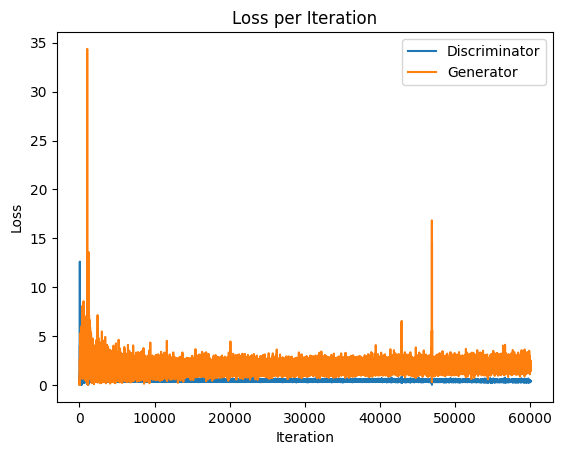

In [19]:
# Plot the Training Loss per Iteration
plt.plot(disc_losses, label='Discriminator')
plt.plot(gen_losses, label='Generator')
plt.title('Loss per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()

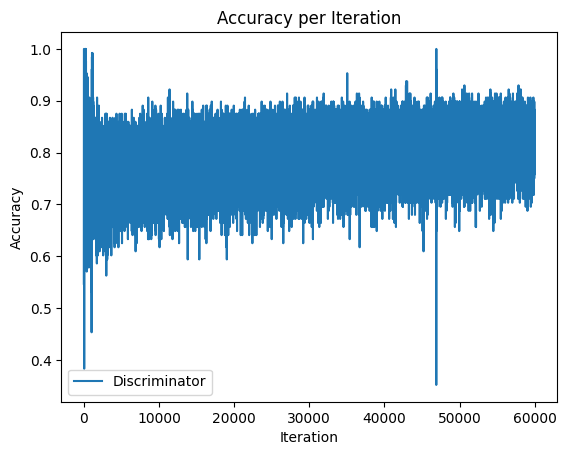

In [20]:
# Plot the Training Loss per Iteration
plt.plot(disc_accs, label='Discriminator')
plt.title('Accuracy per Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()

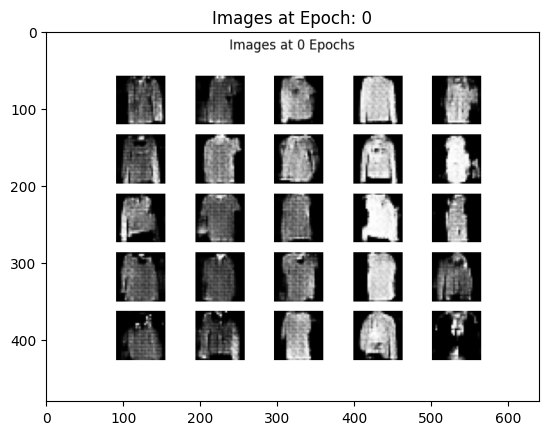

In [21]:
# Generator Results at Epoch 0
a = imread('gan_images/0.png')
plt.title("Images at Epoch: 0")
plt.imshow(a)

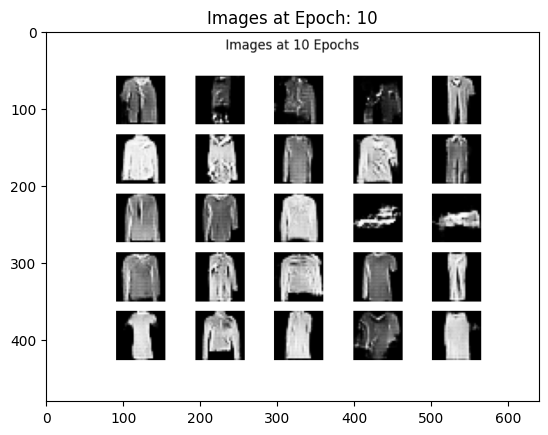

In [22]:
# Generator Results at Epoch 10
a = imread('gan_images/10.png')
plt.title("Images at Epoch: 10")
plt.imshow(a)

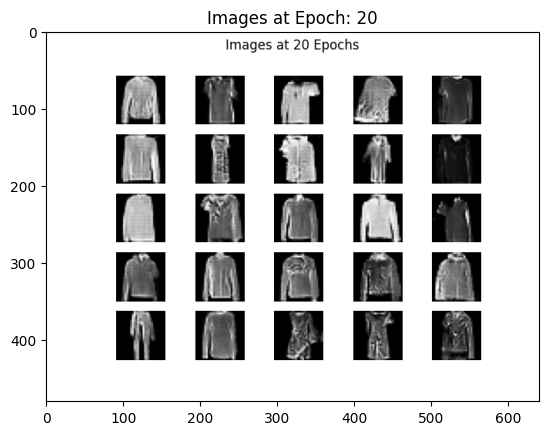

In [23]:
# Generator Results at Epoch 20
a = imread('gan_images/20.png')
plt.title("Images at Epoch: 20")
plt.imshow(a)

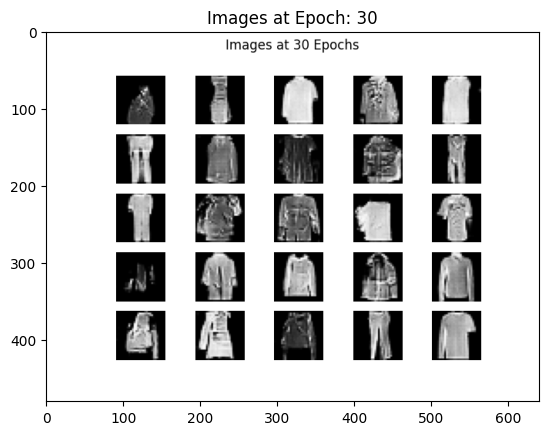

In [24]:
# Generator Results at Epoch 30
a = imread('gan_images/30.png')
plt.title("Images at Epoch: 30")
plt.imshow(a)

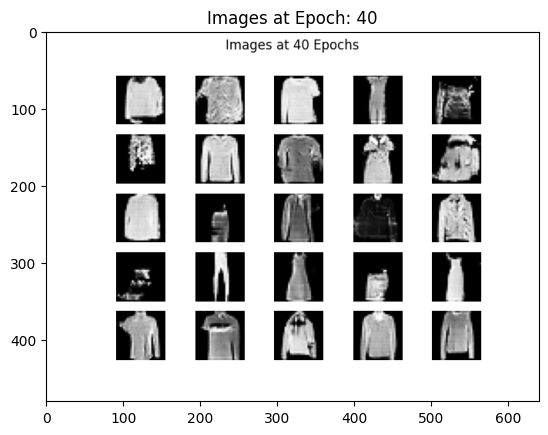

In [25]:
# Generator Results at Epoch 40
a = imread('gan_images/40.png')
plt.title("Images at Epoch: 40")
plt.imshow(a)

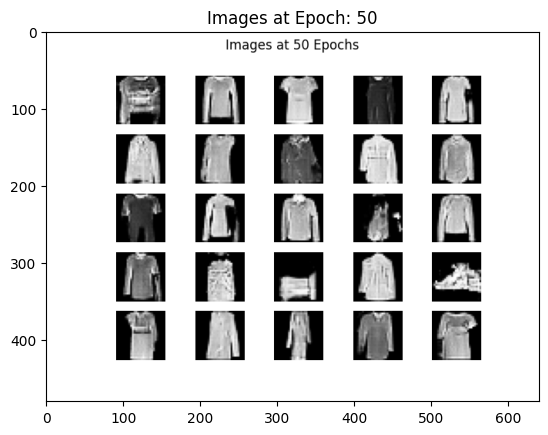

In [26]:
# Generator Results at Epoch 50
a = imread('gan_images/50.png')
plt.title("Images at Epoch: 50")
plt.imshow(a)

# Save the Models

Next save the generator, discriminator, and GAN models to the `models/` directory.

In [27]:
# Create a directory to save models
if not os.path.exists('models'):
  os.makedirs('models')

In [28]:
# Save the Generator
generator.save('models/mnist_generator.keras')

In [29]:
# Save the Discriminator
discriminator.save('models/mnist_discriminator.keras')

In [30]:
# Save the GAN
gan.save('models/mnist_gan.keras')

In [31]:
# Convert gan_images directory to .zip for easy download
!zip -q -r gan_images.zip gan_images

In [32]:
# Convert models directory to .zip for easy download
!zip -q -r models.zip models

# Results

Now, we can utilize our trained generator model to generate synthetic Fashion MNIST images. Below is a comparision of "fake" images generated by our model and "real" images from the Fashion MNIST dataset.

### Generated Images (Fake):

2/2 [==============================] - 0s 89ms/step


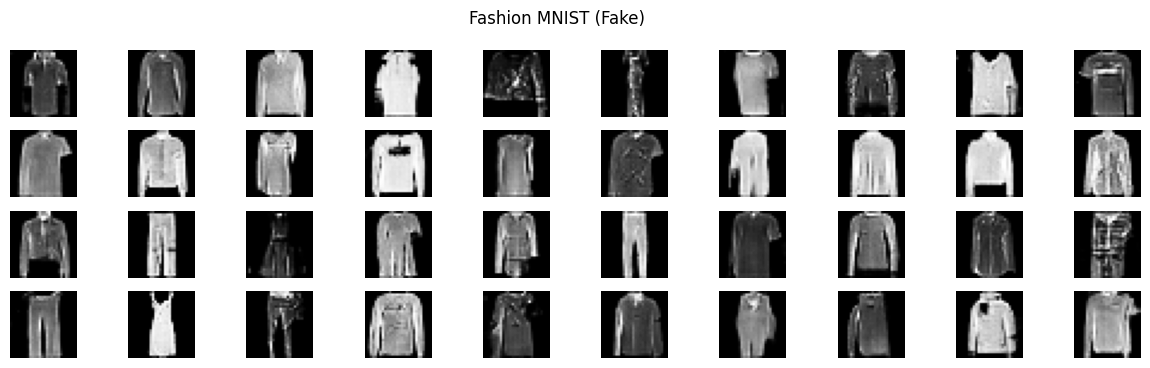

In [33]:
# Plot Generated Images (Fake)
noise = np.random.randn(40, 100)
fake_imgs = generator.predict(noise)

plt.figure(figsize=(15, 4))
plt.suptitle("Fashion MNIST (Fake)")
p = 0
for i in range(40):
    plt.subplot(4, 10, i+1)
    plt.imshow(fake_imgs[p].reshape(28, 28), cmap='gray')
    plt.axis('off')
    p += 1

### Fashion MNIST Images (Real):

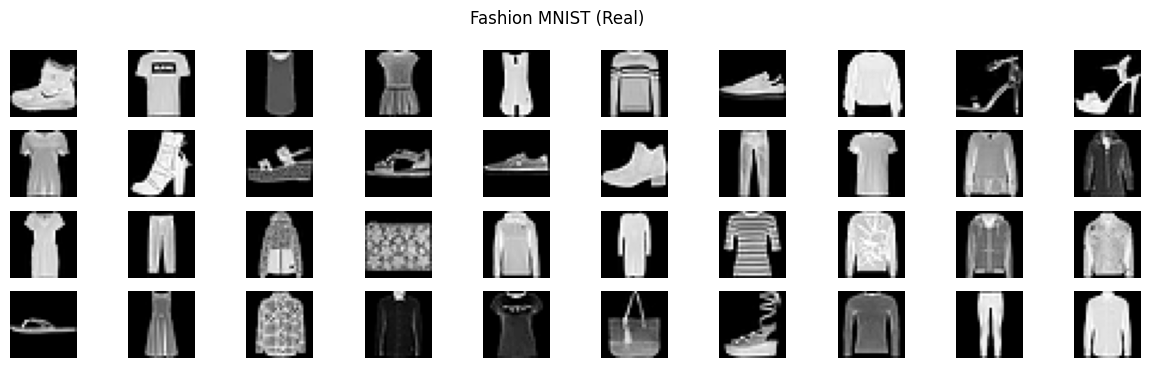

In [34]:
# Plot Fashion MNIST (Real)
plt.figure(figsize=(15, 4), )
plt.suptitle("Fashion MNIST (Real)")
for i in range(40):
    plt.subplot(4, 10, i+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

# References

[1] A. Radford, L. Metz, S. Chintala, "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks," 2016. Available: https://arxiv.org/abs/1406.2661. [Accessed: Fed. 04, 2024].
